# Table of Contents

- [Library Imports](#library-imports)
- [DataFrame Load](#dataframe-load)
- [Pipeline Code for Multiple Models](#pipeline-code-for-multiple-models)
  - [Mean Predictor](#mean-predictor)
  - [Linear Regression](#linear-regression)
  - [Partial Least Squares Regression](#partial-least-squares-regression)
  - [Elastic Net](#elastic-net)
  - [Decision Tree Regressor](#decision-tree-regressor)
  - [Random Forest Regressor](#random-forest-regressor)
  - [Extreme Gradient Boost](#extreme-gradient-boost)
  - [Support Vector Regressor](#support-vector-regressor)
  - [KNeighbors](#kneighbors)
- [Model Evaluation Results Summary](#model-evaluation-results-summary)
    - [RMSE vs. Parameter Value for Each Model](#rmse-vs-parameter-value-for-each-model)
    - [Evaluation of PLS Regression with Leave-One-Group-Out Cross-Validation](#evaluation-of-pls-regression-with-leave-one-group-out-cross-validation)
    - [Random Forest Model LOGO-CV Evaluation](#random-forest-model-logo-cv-evaluation)
- [Final LOGO-CV Model Comparison and Results](#final-logo-cv-model-comparison-and-results)
- [Model Evaluation on Test Subject - Patient 1](#model-evaluation-on-test-subject---patient-1)
- [After Study - Model Performance as Adding More Patients](#after-study---model-performance-as-adding-more-patients)


#### Library Imports

In [2]:
# Numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Timing functions for performance measurement
import time

# Plotting libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns  # Seaborn for advanced plotting and color palettes

# Scikit-learn libraries for building and evaluating models
from sklearn.base import BaseEstimator, RegressorMixin  # Base classes for custom models
from sklearn.pipeline import Pipeline  # Pipeline for chaining preprocessing and modeling
from sklearn.impute import SimpleImputer  # Handling missing values
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Performance metrics
from sklearn.model_selection import LeaveOneGroupOut  # Cross-validation method

# Scikit-learn linear models
from sklearn.linear_model import LinearRegression, ElasticNet  # Linear models

# Scikit-learn tree-based models
from sklearn.tree import DecisionTreeRegressor  # Decision Trees
from sklearn.ensemble import RandomForestRegressor  # Random Forests

# Scikit-learn neighbor-based models
from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors

# Scikit-learn dimensionality reduction
from sklearn.cross_decomposition import PLSRegression  # Partial Least Squares Regression

# XGBoost library for gradient boosting
import xgboost as xgb

# Joblib for parallel computing
from joblib import Parallel, delayed

# Scikit-learn Support Vector Regression
from sklearn.svm import SVR  # Support Vector Regressor

from sklearn.dummy import DummyRegressor


#### DataFrame load

In [3]:
# Load the dataset from a CSV file into a DataFrame
feature_df = pd.read_csv('feature_df.csv')

# Convert the 'datetime' column to datetime format
# This ensures that pandas recognizes the column as dates and times
feature_df['datetime'] = pd.to_datetime(feature_df['datetime'])

# Set the 'datetime' column as the index of the DataFrame
# This allows for time-based indexing and operations
feature_df.set_index('datetime', inplace=True)


#### Pipeline code for multiple models:
- Train on the first quarter of patients 3-16 data
- Test on the first quarter of patient 2
- Preprocess with SimpleImputer (mean) and use StandardScaler
- Calculate MAE, MSE, RMSE, R2, MAPE, Computation Time
- Graph hyperparamter skew
- Graph Predicted vs. Actual data from the test set

In [4]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate the Mean Absolute Percentage Error (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to get the first 25% of each patient's data
def get_first_quarter_data(df, patient_ids):
    """
    Extract the first 25% of data for each specified patient.

    Parameters:
    - df: DataFrame containing the data.
    - patient_ids: List of patient IDs to extract data for.

    Returns:
    - Concatenated DataFrame of the first 25% of data for each patient.
    """
    quarter_data = []
    for patient_id in patient_ids:
        patient_data = df[df['patient_id'] == patient_id]
        quarter_index = int(len(patient_data) * 0.25)  # First 25% of data
        quarter_data.append(patient_data.iloc[:quarter_index])
    return pd.concat(quarter_data)

# Select patients 3-16 and get their first 25% of data for training
train_patient_ids = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
train_first_quarter_data = get_first_quarter_data(feature_df, train_patient_ids)

# Splitting the training data into features and target
X_train = train_first_quarter_data.drop('glucose', axis=1)
y_train = train_first_quarter_data['glucose']

# Selecting only the first 25% of patient 2's data for testing
patient_2_data = feature_df[feature_df['patient_id'] == 2]
quarter_index = int(len(patient_2_data) * 0.25)  # First 25% of data
patient_2_first_quarter = patient_2_data.iloc[:quarter_index]
X_test = patient_2_first_quarter.drop('glucose', axis=1)
y_test = patient_2_first_quarter['glucose']

# Define preprocessing steps including imputation and scaling
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the column mean
    ('scaler', StandardScaler())  # Standardize features
])

# Function to evaluate model performance
def evaluate_model(model, random_state=42):
    """
    Evaluate a model's performance on training and test data.

    Parameters:
    - model: The machine learning model to evaluate.
    - random_state: Seed for random number generation (default: 42).

    Returns:
    - Dictionary containing model performance metrics and predictions.
    """
    # Set random state if the model supports it
    if hasattr(model, 'random_state'):
        try:
            model.set_params(random_state=random_state)
        except ValueError:
            pass

    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    start_time = time.time()

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on both the training and test data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    end_time = time.time()
    computation_time = end_time - start_time

    # Calculate metrics for training data
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)

    # Calculate metrics for test data
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2 = r2_score(y_test, y_test_pred)
    mape = mean_absolute_percentage_error(y_test, y_test_pred)

    # Return metrics and model performance details
    return {
        'model': pipeline,
        'MAE_train': mae_train,
        'MSE_train': mse_train,
        'RMSE_train': rmse_train,
        'MAE_test': mae_test,
        'MSE_test': mse_test,
        'RMSE_test': rmse_test,
        'R2': r2,
        'MAPE': mape,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'computation_time': computation_time
    }

def plot_best_results(indexes, true_values, predicted_values, best_param_value, parameter_name, title):
    """
    Plot the best results comparing true values with predictions.

    Parameters:
    - indexes: Datetime indexes for the x-axis.
    - true_values: Actual values to be plotted.
    - predicted_values: Predicted values to be plotted.
    - best_param_value: Best parameter value used for predictions.
    - parameter_name: Name of the parameter for labeling.
    - title: Title of the plot.
    """
    # Convert indexes to datetime format for better x-axis formatting
    indexes = pd.to_datetime(indexes)

    # Define a color palette
    palette = sns.color_palette("colorblind", 2)  # Use colorblind-friendly palette

    # Create a plot to compare true values with predicted values
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(indexes, true_values, '-', color=palette[0], linewidth=2, label='True Values')
    ax.plot(indexes, predicted_values, '-', color=palette[1], linewidth=2,
            label=f'Predicted Values ({parameter_name}={best_param_value})')

    # Format the x-axis to show only month and day
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

    # Set labels and title
    ax.set_xlabel('')
    ax.set_ylabel('Glucose Value (mg/dL)')
    ax.set_title(f'{title} - First 25% of Patient 2 Data')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    ax.grid(False)
    ax.tick_params(axis='both', direction='in')  # Set ticks inside the plot
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_rmse_vs_parameter(parameter_values, train_rmse_values, test_rmse_values, parameter_name, title):
    """
    Plot RMSE vs parameter values to visualize performance.

    Parameters:
    - parameter_values: List of parameter values.
    - train_rmse_values: Corresponding RMSE values for training data.
    - test_rmse_values: Corresponding RMSE values for test data.
    - parameter_name: Name of the parameter for labeling.
    - title: Title of the plot.
    """
    # Create a plot to compare RMSE with parameter values
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(parameter_values, train_rmse_values, '-', color='cornflowerblue', linewidth=2, label='Training RMSE')
    ax.plot(parameter_values, test_rmse_values, '-', color='mediumorchid', linewidth=2, label='Test RMSE')
    ax.set_xlabel(parameter_name)
    ax.set_ylabel('RMSE')
    ax.set_title(title)

    # Find the parameter value that minimizes the test RMSE
    min_rmse_index = np.argmin(test_rmse_values)
    min_rmse_value = parameter_values[min_rmse_index]

    # Add a vertical line at the minimum RMSE parameter value
    ax.axvline(x=min_rmse_value, color='red', linestyle='--', linewidth=1.5, label=f'Min RMSE ({parameter_name}={min_rmse_value:.2f})')

    # Add annotations
    ax.annotate(f'{min_rmse_value:.2f}',
                xy=(min_rmse_value, min(test_rmse_values)),
                xytext=(min_rmse_value + 0.05, min(test_rmse_values) + 0.05),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    ax.grid(False)

    # If the parameter is 'var_smoothing', set X-axis to log scale
    if parameter_name == 'var_smoothing':
        ax.set_xscale('log')

    plt.tight_layout()
    ax.legend()
    plt.show()

#### Mean Predictor
Test the simplest model to gauge performance of more sophisticated ones

Mean Predictor, RMSE: 26.80
Computation time for the Mean Predictor: 0.05 seconds


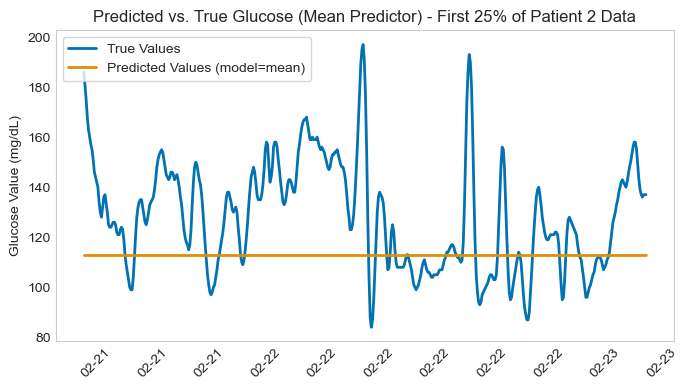

In [5]:
# Define a simple model that predicts the mean of the training target values
class MeanPredictor:
    def fit(self, X, y):
        self.mean_ = np.mean(y)
    
    def predict(self, X):
        return np.full(shape=len(X), fill_value=self.mean_)

# Evaluate the MeanPredictor model
mean_predictor_model = MeanPredictor()
mean_predictor_result = evaluate_model(mean_predictor_model)

# Print the result
print(f"Mean Predictor, RMSE: {mean_predictor_result['RMSE_test']:.2f}")
print(f"Computation time for the Mean Predictor: {mean_predictor_result['computation_time']:.2f} seconds")

# Plot the best result
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    mean_predictor_result['test_predictions'],
    'mean',
    'model',
    'Predicted vs. True Glucose (Mean Predictor)'
)


#### Linear Regression
Test a simple model to gauge performance of more sophisticated ones

Linear Regression, RMSE: 24.27
Computation time for the Linear Regression: 5.31 seconds


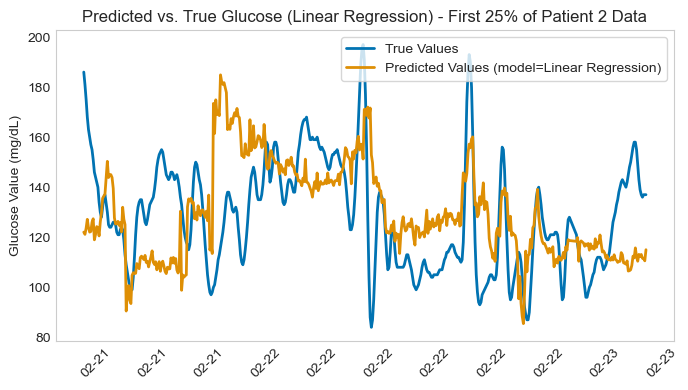

In [6]:
# Evaluate the Linear Regression model
linear_regression_model = LinearRegression()
linear_regression_result = evaluate_model(linear_regression_model)

# Print the result
print(f"Linear Regression, RMSE: {linear_regression_result['RMSE_test']:.2f}")
print(f"Computation time for the Linear Regression: {linear_regression_result['computation_time']:.2f} seconds")

# Plot the best result
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    linear_regression_result['test_predictions'],
    'Linear Regression',
    'model',
    'Predicted vs. True Glucose (Linear Regression)'
)

#### Partial Lease Squares Regression
n_components hyperparameter skew

Best n_components: 16
PLS Regression with optimized n_components, Test RMSE: 21.43
Computation time for the best model: 0.33 seconds


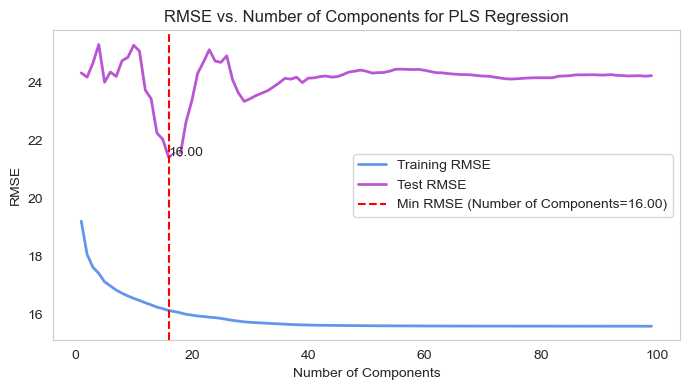

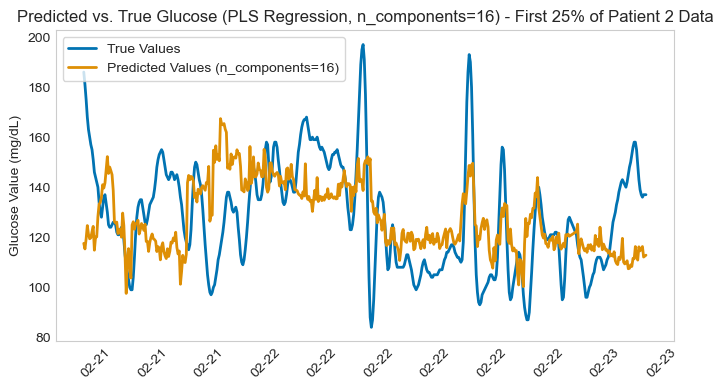

In [7]:
# Define a function to evaluate PLS Regression models with varying n_components
def evaluate_pls(n_components, X_train, y_train, X_test, y_test):
    model = PLSRegression(n_components=n_components)
    result = evaluate_model(model)
    result['n_components'] = n_components
    return result

# Define the range of n_components values to test
n_components_values = np.arange(1, min(X_train.shape[1], 100))  # Ensure n_components is less than number of features

# Evaluate models in parallel
pls_results = Parallel(n_jobs=-1)(
    delayed(evaluate_pls)(n, X_train, y_train, X_test, y_test)
    for n in n_components_values
)

# Extract metrics for plotting
train_rmse_pls_values = [result['RMSE_train'] for result in pls_results]  # Renamed for PLS
test_rmse_pls_values = [result['RMSE_test'] for result in pls_results]    # Renamed for PLS

# Find the best n_components
pls_best_index = np.argmin(test_rmse_pls_values)
pls_best_n_components = n_components_values[pls_best_index]
pls_best_result = pls_results[pls_best_index]

print(f"Best n_components: {pls_best_n_components}")
print(f"PLS Regression with optimized n_components, Test RMSE: {pls_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {pls_best_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. n_components
plot_rmse_vs_parameter(
    n_components_values,
    train_rmse_pls_values,  # Renamed for PLS
    test_rmse_pls_values,   # Renamed for PLS
    'Number of Components',
    'RMSE vs. Number of Components for PLS Regression'
)

# Use the plotting function to visualize the results of the best n_components
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    pls_best_result['test_predictions'],
    pls_best_n_components,
    'n_components',
    f'Predicted vs. True Glucose (PLS Regression, n_components={pls_best_n_components})'
)


#### Elastic Net
Alpha and L1 hyperparamter skew

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.911e+05, tolerance: 2.451e+02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+03, tolerance: 2.451e+02
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.026915348039269166
Elastic Net with optimized alpha, Test RMSE: 21.52
Computation time for the best model: 1.12 seconds


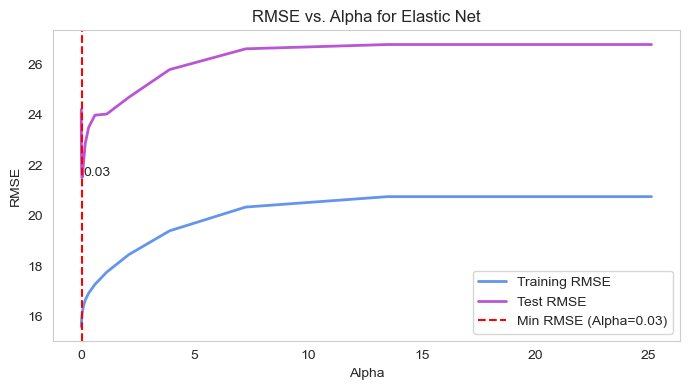

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.466e+05, tolerance: 2.451e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Best l1_ratio: 0.35000000000000003
Elastic Net with optimized l1_ratio, Test RMSE: 23.94
Computation time for the best model: 0.11 seconds


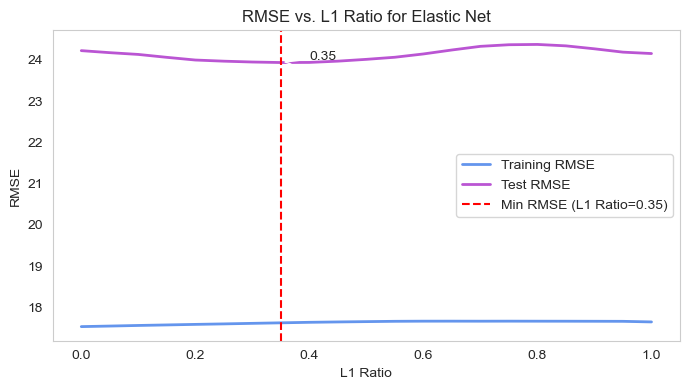

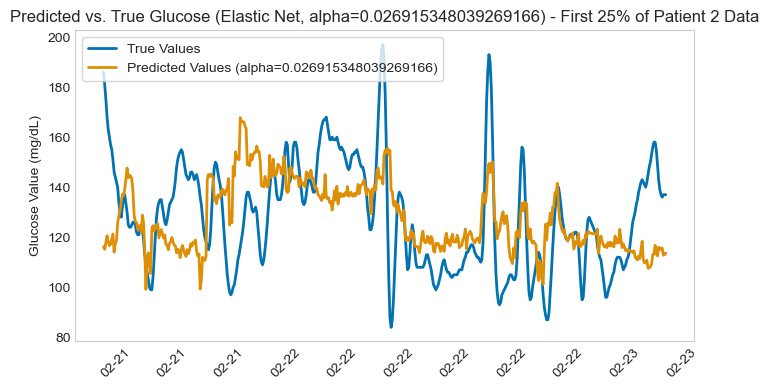

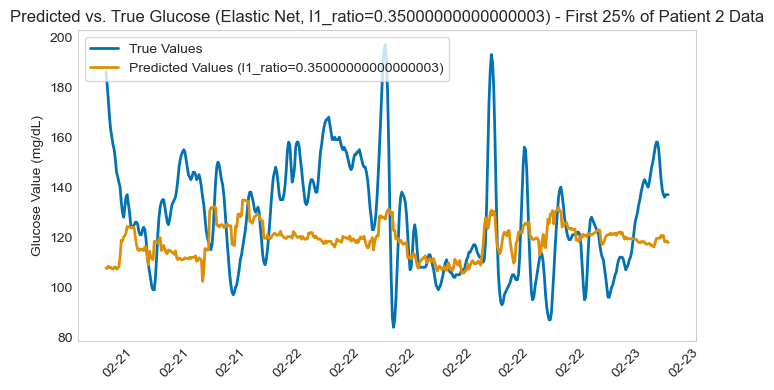

In [8]:
# Define the range of alpha values to test
alpha_values = np.logspace(-4, 1.4, 21)  # Example: from 1e-4 to 1e4

# Define the range of l1_ratio values to test
l1_ratio_values = np.linspace(0, 1, 21)  # Example: from 0 to 1

# Function to evaluate Elastic Net model with specified alpha and l1_ratio
def evaluate_elastic_net(alpha, l1_ratio):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=20000)  # Increase max_iter for convergence
    return evaluate_model(model)

# Evaluate models in parallel for different alpha values
elastic_net_alpha_results = Parallel(n_jobs=-1)(
    delayed(evaluate_elastic_net)(alpha, 0.5) for alpha in alpha_values
)

# Extract metrics for plotting
elastic_net_alpha_rmse_train_values = [result['RMSE_train'] for result in elastic_net_alpha_results]
elastic_net_alpha_rmse_test_values = [result['RMSE_test'] for result in elastic_net_alpha_results]

# Find the best alpha
elastic_net_alpha_best_index = np.argmin(elastic_net_alpha_rmse_test_values)
elastic_net_alpha_best_value = alpha_values[elastic_net_alpha_best_index]
elastic_net_alpha_best_result = elastic_net_alpha_results[elastic_net_alpha_best_index]

print(f"Best alpha: {elastic_net_alpha_best_value}")
print(f"Elastic Net with optimized alpha, Test RMSE: {elastic_net_alpha_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {elastic_net_alpha_best_result['computation_time']:.2f} seconds")

# Plot RMSE vs. alpha
plot_rmse_vs_parameter(
    alpha_values,
    elastic_net_alpha_rmse_train_values,
    elastic_net_alpha_rmse_test_values,
    'Alpha',
    'RMSE vs. Alpha for Elastic Net'
)

# Evaluate models in parallel for different l1_ratio values
elastic_net_l1_ratio_results = Parallel(n_jobs=-1)(
    delayed(evaluate_elastic_net)(1.0, l1_ratio) for l1_ratio in l1_ratio_values
)

# Extract metrics for plotting
elastic_net_l1_ratio_rmse_train_values = [result['RMSE_train'] for result in elastic_net_l1_ratio_results]
elastic_net_l1_ratio_rmse_test_values = [result['RMSE_test'] for result in elastic_net_l1_ratio_results]

# Find the best l1_ratio
elastic_net_l1_ratio_best_index = np.argmin(elastic_net_l1_ratio_rmse_test_values)
elastic_net_l1_ratio_best_value = l1_ratio_values[elastic_net_l1_ratio_best_index]
elastic_net_l1_ratio_best_result = elastic_net_l1_ratio_results[elastic_net_l1_ratio_best_index]

print(f"Best l1_ratio: {elastic_net_l1_ratio_best_value}")
print(f"Elastic Net with optimized l1_ratio, Test RMSE: {elastic_net_l1_ratio_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {elastic_net_l1_ratio_best_result['computation_time']:.2f} seconds")

# Plot RMSE vs. l1_ratio
plot_rmse_vs_parameter(
    l1_ratio_values,
    elastic_net_l1_ratio_rmse_train_values,
    elastic_net_l1_ratio_rmse_test_values,
    'L1 Ratio',
    'RMSE vs. L1 Ratio for Elastic Net'
)

# Plot results for the best alpha
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    elastic_net_alpha_best_result['test_predictions'],
    elastic_net_alpha_best_value,
    'alpha',
    f'Predicted vs. True Glucose (Elastic Net, alpha={elastic_net_alpha_best_value})'
)

# Plot results for the best l1_ratio
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    elastic_net_l1_ratio_best_result['test_predictions'],
    elastic_net_l1_ratio_best_value,
    'l1_ratio',
    f'Predicted vs. True Glucose (Elastic Net, l1_ratio={elastic_net_l1_ratio_best_value})'
)


#### Decision Tree Regressor
Max_Depth hyperparamter skew

Best max_depth: 2
Decision Tree Regressor with optimized max_depth, Test RMSE: 23.82
Computation time for the best model: 0.26 seconds


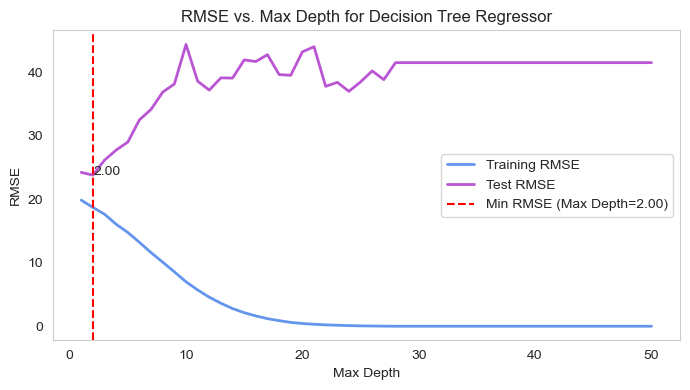

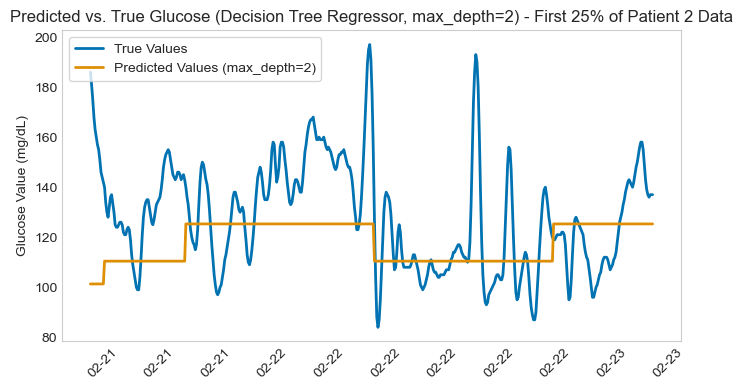

In [9]:
# Define a function to evaluate models with varying max_depth
def evaluate_decision_tree(max_depth, X_train, y_train, X_test, y_test):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=2, min_samples_leaf=1)
    result = evaluate_model(model)
    result['max_depth'] = max_depth
    return result

# Define the range of max_depth values to test
max_depth_values = np.arange(1, 51)  # 1 to 50

# Evaluate models in parallel
decision_tree_results = Parallel(n_jobs=-1)(
    delayed(evaluate_decision_tree)(depth, X_train, y_train, X_test, y_test)
    for depth in max_depth_values
)

# Extract metrics for plotting
decision_tree_train_rmse_values = [result['RMSE_train'] for result in decision_tree_results]
decision_tree_test_rmse_values = [result['RMSE_test'] for result in decision_tree_results]

# Find the best max_depth
decision_tree_best_index = np.argmin(decision_tree_test_rmse_values)
decision_tree_best_max_depth = max_depth_values[decision_tree_best_index]
decision_tree_best_result = decision_tree_results[decision_tree_best_index]

print(f"Best max_depth: {decision_tree_best_max_depth}")
print(f"Decision Tree Regressor with optimized max_depth, Test RMSE: {decision_tree_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {decision_tree_best_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. max_depth
plot_rmse_vs_parameter(
    max_depth_values,
    decision_tree_train_rmse_values,
    decision_tree_test_rmse_values,
    'Max Depth',
    'RMSE vs. Max Depth for Decision Tree Regressor'
)

# Use the plotting function to visualize the results of the best max_depth
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    decision_tree_best_result['test_predictions'],
    decision_tree_best_max_depth,
    'max_depth',
    f'Predicted vs. True Glucose (Decision Tree Regressor, max_depth={decision_tree_best_max_depth})'
)


#### Random Forest Regressor
n_estimator parameter skew

Best min_samples_leaf: 106
Random Forest Regressor with optimized min_samples_leaf, Test RMSE: 24.48
Computation time for the best model: 25.57 seconds


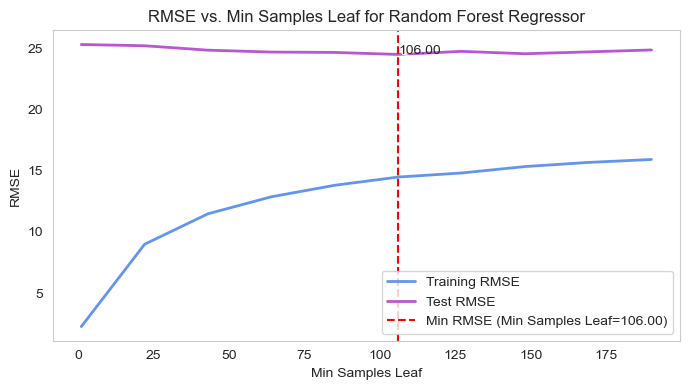

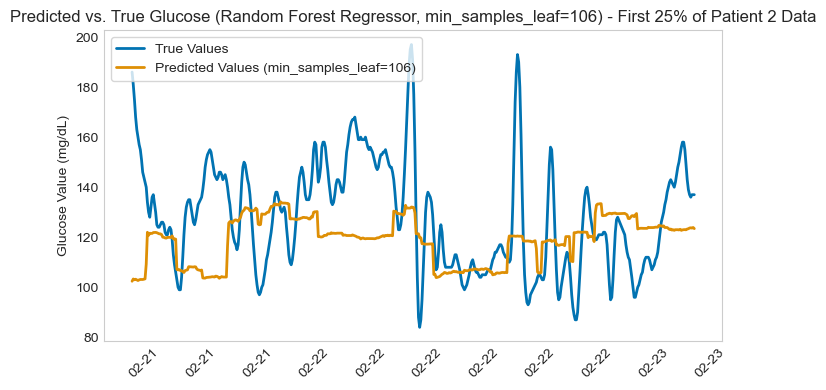

In [10]:
# Define a function to evaluate Random Forest models with a fixed number of estimators and varying min_samples_leaf
def evaluate_random_forest(min_samples_leaf, X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(
        n_estimators=100,  # Fixed number of estimators
        min_samples_leaf=min_samples_leaf,  # Variable value
        random_state=42,
        max_features=None
    )
    result = evaluate_model(model)
    result['n_estimators'] = 100
    result['min_samples_leaf'] = min_samples_leaf
    result['max_features'] = model.max_features
    return result

# Define the range of min_samples_leaf values to test
min_samples_leaf_values = np.arange(1, 201, 21)  # Skewing from 1 to 200

# Evaluate models in parallel for each min_samples_leaf value
random_forest_results = Parallel(n_jobs=-1)(
    delayed(evaluate_random_forest)(m, X_train, y_train, X_test, y_test)
    for m in min_samples_leaf_values
)

# Extract metrics for plotting
random_forest_train_rmse_values = [result['RMSE_train'] for result in random_forest_results]
random_forest_test_rmse_values = [result['RMSE_test'] for result in random_forest_results]

# Find the best min_samples_leaf
random_forest_best_index = np.argmin(random_forest_test_rmse_values)
random_forest_best_result = random_forest_results[random_forest_best_index]
random_forest_best_min_samples_leaf = random_forest_best_result['min_samples_leaf']

print(f"Best min_samples_leaf: {random_forest_best_min_samples_leaf}")
print(f"Random Forest Regressor with optimized min_samples_leaf, Test RMSE: {random_forest_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {random_forest_best_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. min_samples_leaf
plot_rmse_vs_parameter(
    min_samples_leaf_values,
    random_forest_train_rmse_values,
    random_forest_test_rmse_values,
    'Min Samples Leaf',
    'RMSE vs. Min Samples Leaf for Random Forest Regressor'
)

# Use the plotting function to visualize the results of the best min_samples_leaf
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    random_forest_best_result['test_predictions'],
    random_forest_best_min_samples_leaf,
    'min_samples_leaf',
    f'Predicted vs. True Glucose (Random Forest Regressor, min_samples_leaf={random_forest_best_min_samples_leaf})'
)


#### Extreme Gradient Boost
max_depth hyperparameter skew

Best max_depth: 7
XGBoost Regressor with optimized max_depth, Test RMSE: 21.99
Computation time for the best model: 5.63 seconds


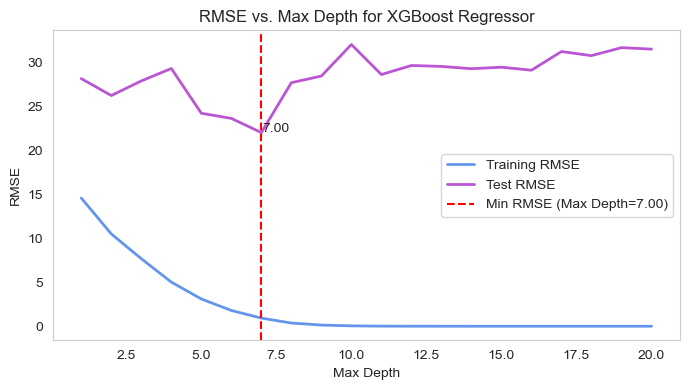

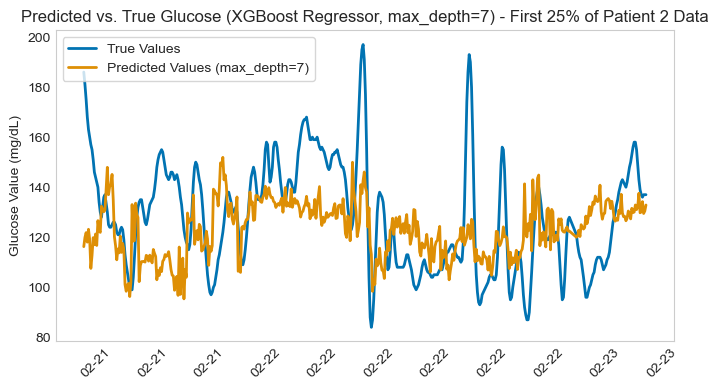

In [11]:
# Define a function to evaluate XGBoost models with varying max_depth
def evaluate_xgboost(max_depth, X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(max_depth=max_depth, random_state=42)  # Added random_state for reproducibility
    result = evaluate_model(model)
    result['max_depth'] = max_depth
    return result

# Define the range of max_depth values to test
xgb_max_depth_values = np.arange(1, 21, 1)  # Example range from 1 to 20

# Evaluate models in parallel
xgboost_results = Parallel(n_jobs=-1)(
    delayed(evaluate_xgboost)(d, X_train, y_train, X_test, y_test)
    for d in xgb_max_depth_values
)

# Extract metrics for plotting
xgboost_train_rmse_values = [result['RMSE_train'] for result in xgboost_results]
xgboost_test_rmse_values = [result['RMSE_test'] for result in xgboost_results]

# Find the best max_depth
xgboost_best_index = np.argmin(xgboost_test_rmse_values)
xgboost_best_max_depth = xgb_max_depth_values[xgboost_best_index]
xgboost_best_result = xgboost_results[xgboost_best_index]

print(f"Best max_depth: {xgboost_best_max_depth}")
print(f"XGBoost Regressor with optimized max_depth, Test RMSE: {xgboost_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {xgboost_best_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. max_depth
plot_rmse_vs_parameter(
    xgb_max_depth_values,
    xgboost_train_rmse_values,
    xgboost_test_rmse_values,
    'Max Depth',
    'RMSE vs. Max Depth for XGBoost Regressor'
)

# Use the plotting function to visualize the results of the best max_depth
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    xgboost_best_result['test_predictions'],
    xgboost_best_max_depth,
    'max_depth',
    f'Predicted vs. True Glucose (XGBoost Regressor, max_depth={xgboost_best_max_depth})'
)


#### Support Vector Regressor
C_values hyperparameter skew

Best C: 2.818382931264452
SVR with optimized C, Test RMSE: 25.12
Computation time for the best model: 19.28 seconds


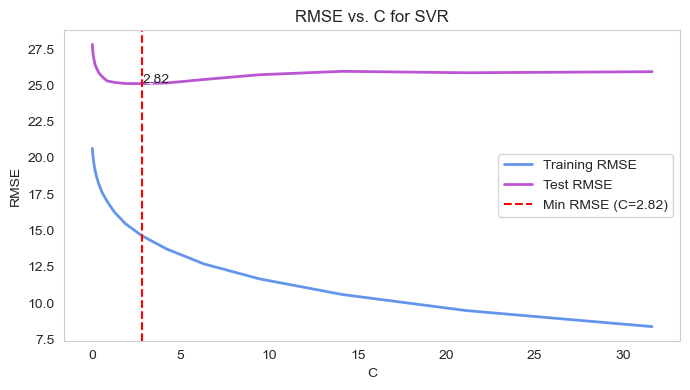

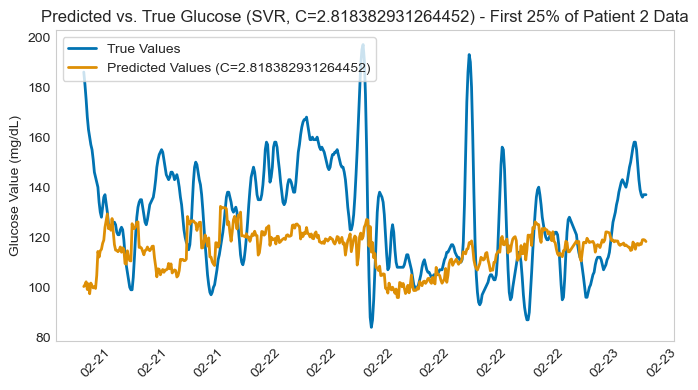

In [12]:

# Define a function to evaluate SVR models with varying C
def evaluate_svr(C, X_train, y_train, X_test, y_test):
    model = SVR(C=C, epsilon=0.1)  # You can adjust epsilon if needed
    result = evaluate_model(model)
    result['C'] = C
    return result

# Define the range of C values to test
C_values = np.logspace(-2, 1.5, 21)  # Example range from 0.01 to 100

# Evaluate models in parallel
svr_evaluation_results = Parallel(n_jobs=-1)(
    delayed(evaluate_svr)(C, X_train, y_train, X_test, y_test)
    for C in C_values
)

# Extract metrics for plotting
svr_train_rmse_values = [result['RMSE_train'] for result in svr_evaluation_results]
svr_test_rmse_values = [result['RMSE_test'] for result in svr_evaluation_results]

# Find the best C
svr_best_index = np.argmin(svr_test_rmse_values)
svr_best_C = C_values[svr_best_index]
svr_best_result = svr_evaluation_results[svr_best_index]

print(f"Best C: {svr_best_C}")
print(f"SVR with optimized C, Test RMSE: {svr_best_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {svr_best_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. C
plot_rmse_vs_parameter(
    C_values,
    svr_train_rmse_values,
    svr_test_rmse_values,
    'C',
    'RMSE vs. C for SVR'
)

# Use the plotting function to visualize the results of the best C
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    svr_best_result['test_predictions'],
    svr_best_C,
    'C',
    f'Predicted vs. True Glucose (SVR, C={svr_best_C})'
)


#### KNeighbors
n_neighbors hyperparameter skew

Best n_neighbors: 230
KNN Regressor with optimized n_neighbors, Test RMSE: 25.76
Computation time for the best model: 1.60 seconds


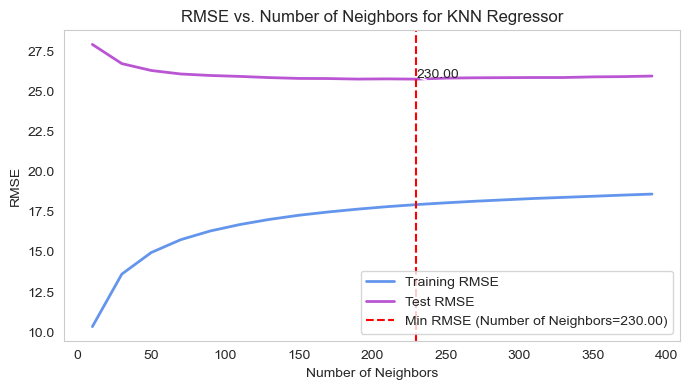

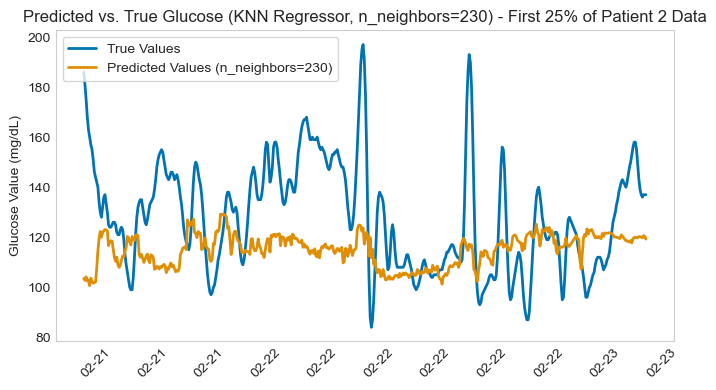

In [13]:
# Define a function to evaluate KNN models with varying n_neighbors
def evaluate_knn(n_neighbors, X_train, y_train, X_test, y_test):
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    result = evaluate_model(model)
    result['n_neighbors'] = n_neighbors
    return result

# Define the range of n_neighbors values to test
n_neighbors_values = np.arange(10, 401, 20)  # Range from 10 to 400 in intervals of 20

# Evaluate models in parallel
knn_results = Parallel(n_jobs=-1)(
    delayed(evaluate_knn)(n, X_train, y_train, X_test, y_test)
    for n in n_neighbors_values
)

# Extract metrics for plotting
train_rmse_knn_values = [result['RMSE_train'] for result in knn_results]  # Renamed for KNN
test_rmse_knn_values = [result['RMSE_test'] for result in knn_results]    # Renamed for KNN

# Find the best n_neighbors
best_index = np.argmin(test_rmse_knn_values)
best_n_neighbors = n_neighbors_values[best_index]
best_knn_result = knn_results[best_index]  # Renamed variable

print(f"Best n_neighbors: {best_n_neighbors}")
print(f"KNN Regressor with optimized n_neighbors, Test RMSE: {best_knn_result['RMSE_test']:.2f}")
print(f"Computation time for the best model: {best_knn_result['computation_time']:.2f} seconds")

# Use the plotting function to visualize RMSE vs. n_neighbors
plot_rmse_vs_parameter(
    n_neighbors_values,
    train_rmse_knn_values,  # Renamed for KNN
    test_rmse_knn_values,   # Renamed for KNN
    'Number of Neighbors',
    'RMSE vs. Number of Neighbors for KNN Regressor'
)

# Use the plotting function to visualize the results of the best n_neighbors
plot_best_results(
    patient_2_first_quarter.index,
    y_test,
    best_knn_result['test_predictions'],
    best_n_neighbors,
    'n_neighbors',
    f'Predicted vs. True Glucose (KNN Regressor, n_neighbors={best_n_neighbors})'
)


#### Model Evaluation Results Summary

This section presents a summary of the evaluation results for various regression models.

In [14]:
# Create a dictionary with all model results
model_results = {
    'Mean Predictor': mean_predictor_result,
    'Linear Regression': linear_regression_result,
    'Partial Least Squares Regression': pls_best_result,
    'Elastic Net Regression (Best Alpha)': elastic_net_alpha_best_result,
    'Elastic Net Regression (Best L1 Ratio)': elastic_net_l1_ratio_best_result,
    'Decision Tree Regressor': decision_tree_best_result,
    'Random Forest Regressor': random_forest_best_result,
    'XGBoost Regressor': xgboost_best_result,
    'Support Vector Regressor': svr_best_result,
    'K-Nearest Neighbors Regressor': best_knn_result
}

# Collect all the results in a list
results = []
for model_name, result in model_results.items():
    results.append({
        'Model': model_name,
        'MAE_test': result.get('MAE_test', np.nan),  # Using np.nan in case MAE is not present
        'MSE_test': result.get('MSE_test', np.nan),
        'RMSE_test': result.get('RMSE_test', np.nan),
        'R2': result.get('R2', np.nan),
        'MAPE': result.get('MAPE', np.nan),
        'Computation Time (s)': result.get('computation_time', np.nan)
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
print(results_df)


                                    Model   MAE_test    MSE_test  RMSE_test  \
0                          Mean Predictor  20.955473  718.162138  26.798547   
1                       Linear Regression  19.423714  588.799216  24.265185   
2        Partial Least Squares Regression  16.896272  459.381632  21.433190   
3     Elastic Net Regression (Best Alpha)  16.906728  463.000145  21.517438   
4  Elastic Net Regression (Best L1 Ratio)  18.746996  572.958386  23.936549   
5                 Decision Tree Regressor  18.343613  567.411804  23.820407   
6                 Random Forest Regressor  19.038803  599.078030  24.476071   
7                       XGBoost Regressor  17.519259  483.425099  21.986930   
8                Support Vector Regressor  19.282049  630.986888  25.119452   
9           K-Nearest Neighbors Regressor  20.081227  663.419600  25.756933   

         R2       MAPE  Computation Time (s)  
0 -0.511990  15.042520              0.047957  
1 -0.239634  15.590543              

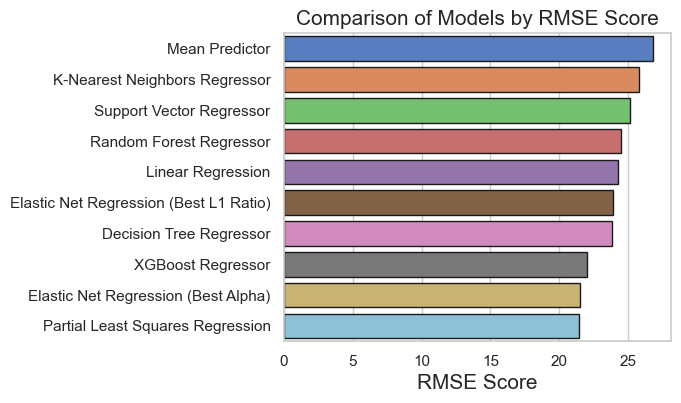

In [24]:
sns.set(style="whitegrid")

# Sort the DataFrame based on RMSE score
results_df.sort_values('RMSE_test', inplace=True, ascending=False)

# Create bar chart
plt.figure(figsize=(5, 4))
chart = sns.barplot(x='RMSE_test', y='Model', data=results_df, errorbar=None, palette='muted', orient='h', edgecolor='k')

# Add labels and title
plt.xlabel('RMSE Score', size=15)
plt.ylabel('')  # Remove y-label
plt.title('Comparison of Models by RMSE Score', size=15)

# Display plot
plt.show()


In [16]:
# Create dictionary of parameters and RMSE values for each model
model_rmse_vs_params = {
    'PLS Regression': {
        'parameter_values': n_components_values, 
        'train_rmse_values': train_rmse_pls_values,  # Train RMSE values
        'test_rmse_values': test_rmse_pls_values,
        'parameter_name': 'Number of Components'
    },
    'Elastic Net (Best Alpha)': {
        'parameter_values': alpha_values, 
        'train_rmse_values': elastic_net_alpha_rmse_train_values,  # Train RMSE values
        'test_rmse_values': elastic_net_alpha_rmse_test_values,
        'parameter_name': 'Alpha'
    },
    'Elastic Net (Best L1 Ratio)': {
        'parameter_values': l1_ratio_values, 
        'train_rmse_values': elastic_net_l1_ratio_rmse_train_values,  # Train RMSE values
        'test_rmse_values': elastic_net_l1_ratio_rmse_test_values,
        'parameter_name': 'L1 Ratio'
    },
    'Decision Tree': {
        'parameter_values': max_depth_values, 
        'train_rmse_values': decision_tree_train_rmse_values,  # Train RMSE values
        'test_rmse_values': decision_tree_test_rmse_values,
        'parameter_name': 'Max Depth'
    },
    'Random Forest': {
        'parameter_values': min_samples_leaf_values, 
        'train_rmse_values': random_forest_train_rmse_values,  # Train RMSE values
        'test_rmse_values': random_forest_test_rmse_values,
        'parameter_name': 'Min Samples Leaf'
    },
    'XGBoost': {
        'parameter_values': xgb_max_depth_values,
        'train_rmse_values': xgboost_train_rmse_values,  # Train RMSE values
        'test_rmse_values': xgboost_test_rmse_values,
        'parameter_name': 'Max Depth'
    },
    'SVR': {
        'parameter_values': C_values, 
        'train_rmse_values': svr_train_rmse_values,  # Train RMSE values
        'test_rmse_values': svr_test_rmse_values,
        'parameter_name': 'C'
    },
    'K-Nearest Neighbors': {
        'parameter_values': n_neighbors_values, 
        'train_rmse_values': train_rmse_knn_values,  # Train RMSE values
        'test_rmse_values': test_rmse_knn_values,
        'parameter_name': 'Number of Neighbors'
    },
}


#### RMSE vs. Parameter Value for Each Model

This set of plots shows the RMSE (Root Mean Squared Error) for training and test datasets as a function of the parameter values for each model. The vertical red dashed line indicates the parameter value that results in the lowest test RMSE for each model.


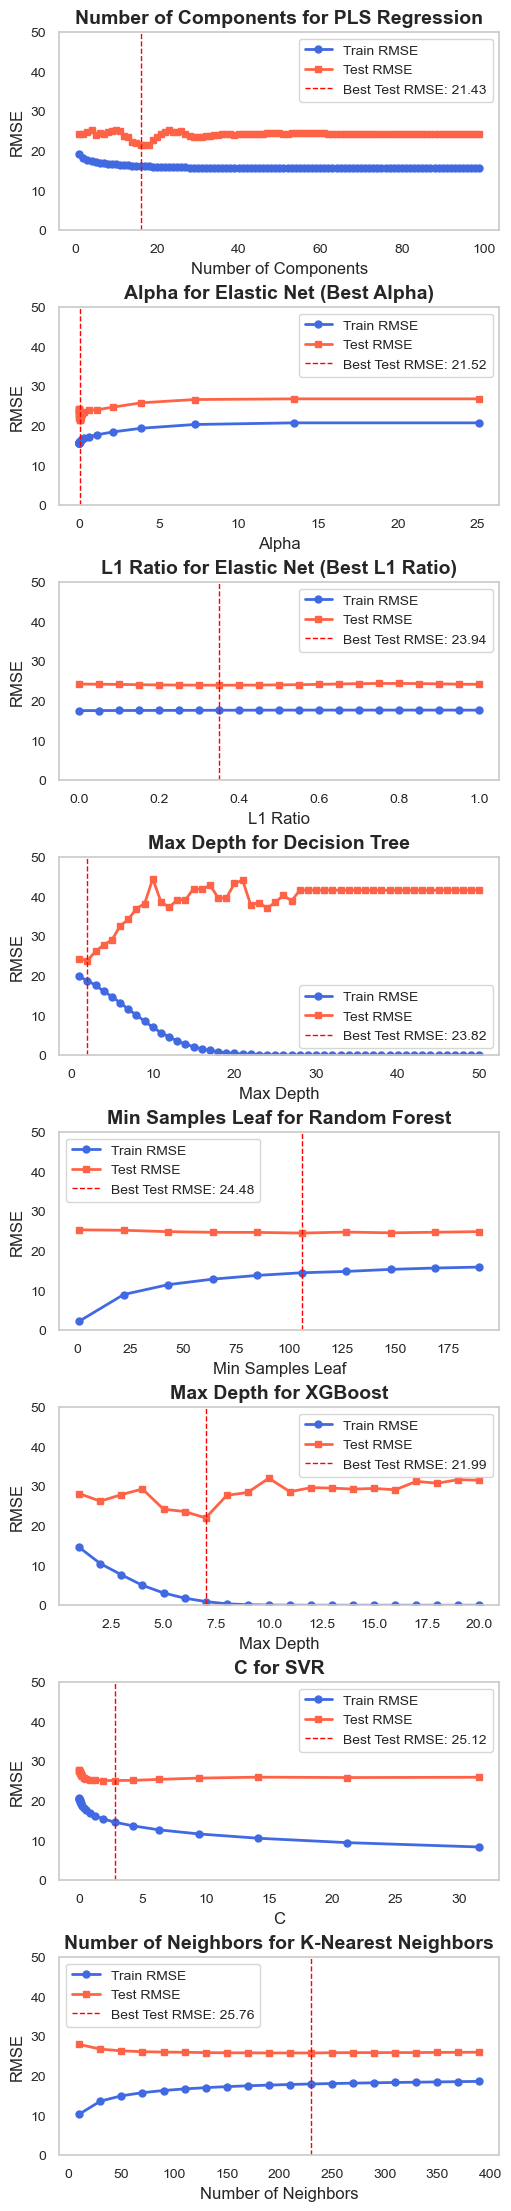

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Number of models
num_models = len(model_rmse_vs_params)

# Define grid size for 2 columns and 4 rows
num_cols = 1
num_rows = 8  # 8 graphs -> 4 rows with 2 columns each

# Create subplots with adjusted figure size for 2x4 layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 22), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define a single color scheme for training and testing RMSE
train_color = 'royalblue'
test_color = 'tomato'

# Plot each model's results
for idx, (model_name, model_results) in enumerate(model_rmse_vs_params.items()):
    ax = axes[idx]
    
    # Extract values
    param_values = model_results['parameter_values']
    train_rmse_values = model_results['train_rmse_values']
    test_rmse_values = model_results['test_rmse_values']
    parameter_name = model_results['parameter_name']
    
    # Find the parameter value with the minimum test RMSE
    min_rmse_idx = np.argmin(test_rmse_values)
    best_param_value = param_values[min_rmse_idx]
    best_rmse_value = test_rmse_values[min_rmse_idx]
    
    # Plot Training RMSE vs. parameter with markers
    ax.plot(param_values, train_rmse_values, '-', color=train_color, linewidth=2, marker='o', markersize=5, label='Train RMSE')
    
    # Plot Testing RMSE vs. parameter with markers
    ax.plot(param_values, test_rmse_values, '-', color=test_color, linewidth=2, marker='s', markersize=5, label='Test RMSE')
    
    # Add vertical line at the best parameter value for test RMSE
    ax.axvline(x=best_param_value, color='red', linestyle='--', linewidth=1, label=f'Best Test RMSE: {best_rmse_value:.2f}')
    
    # Set labels, title, and y-axis limits
    ax.set_xlabel(parameter_name, fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_title(f'{parameter_name} for {model_name}', fontweight='bold', fontsize=14)
    ax.set_ylim(0, 50)
    
    # Customize plot appearance
    ax.grid(False)
    ax.legend(fontsize=10)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=10)

# Hide any unused subplots
for idx in range(num_models, len(axes)):
    fig.delaxes(axes[idx])

# Show plot
plt.show()


#### Evaluation of PLS Regression with Leave-One-Group-Out Cross-Validation

This analysis evaluates the performance of Partial Least Squares (PLS) Regression models with varying numbers of components using Leave-One-Group-Out (LOGO) cross-validation. The plots display the average RMSE (Root Mean Squared Error) for different numbers of components.

- Plot shows the average RMSE as a function of the number of PLS components.
- A red vertical dashed line indicates the number of components that yields the lowest RMSE, and the best RMSE value is annotated on the plot.


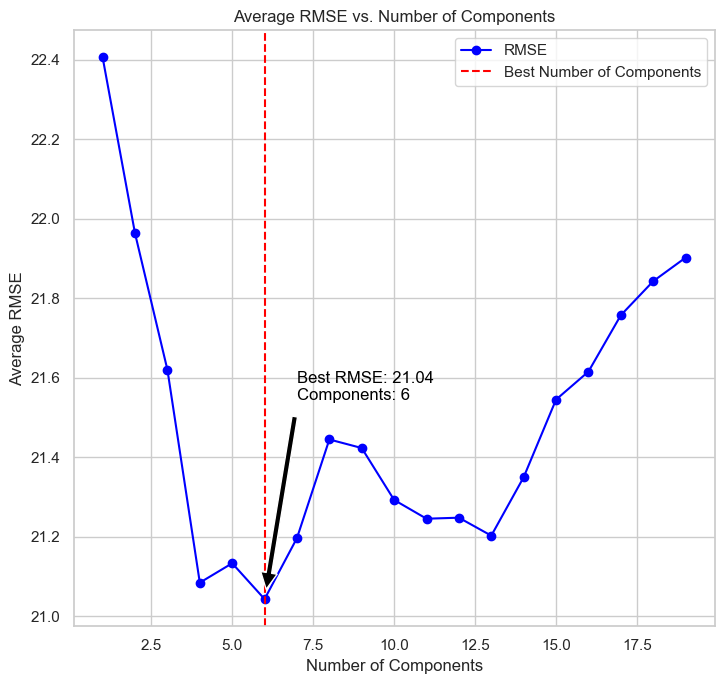

In [42]:
# Define feature columns and target variable
feature_columns = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
X = feature_df[feature_columns]
y = feature_df['glucose']

# Extract patient IDs for Leave-One-Group-Out cross-validation
groups = feature_df['patient_id']

# Filter out data for patient 1
mask = ~feature_df['patient_id'].isin([1])
X_filtered, y_filtered, groups_filtered = X[mask], y[mask], groups[mask]

# Define preprocessing steps
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model performance with LOGO CV
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()

    # Create and fit pipeline
    model_pipeline = Pipeline([
        ('preprocessor', pipeline),
        ('regressor', model)
    ])
    model_pipeline.fit(X_train, y_train)

    # Predict and calculate metrics
    y_pred = model_pipeline.predict(X_test)
    computation_time = time.time() - start_time

    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'computation_time': computation_time
    }

    return metrics

# Initialize Leave-One-Group-Out cross-validation
logo = LeaveOneGroupOut()

# Store results for each n_components
results = {n: {metric: [] for metric in ['MAE', 'MSE', 'RMSE', 'R2', 'MAPE', 'computation_time']} 
           for n in range(1, 20)}

# Perform cross-validation
for train_idx, test_idx in logo.split(X_filtered, y_filtered, groups=groups_filtered):
    X_train, X_test = X_filtered.iloc[train_idx], X_filtered.iloc[test_idx]
    y_train, y_test = y_filtered.iloc[train_idx], y_filtered.iloc[test_idx]

    for n_components in results.keys():
        pls = PLSRegression(n_components=n_components)
        metrics = evaluate_model(pls, X_train, y_train, X_test, y_test)
        
        for metric, value in metrics.items():
            results[n_components][metric].append(value)

# Calculate average scores for each n_components
avg_results = {n: {metric: np.mean(values) for metric, values in metrics.items()} 
               for n, metrics in results.items()}

# Plot the results
components = list(avg_results.keys())
avg_rmse = [avg_results[n]['RMSE'] for n in components]

plt.figure(figsize=(14, 7))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(components, avg_rmse, marker='o', color='blue', label='RMSE')
plt.xlabel('Number of Components')
plt.ylabel('Average RMSE')
plt.title('Average RMSE vs. Number of Components')

# Annotate best RMSE
best_rmse_idx = np.argmin(avg_rmse)
best_rmse = avg_rmse[best_rmse_idx]
best_n_components = components[best_rmse_idx]
plt.annotate(f'Best RMSE: {best_rmse:.2f}\nComponents: {best_n_components}',
             xy=(best_n_components, best_rmse),
             xytext=(best_n_components + 1, best_rmse + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12,
             color='black')

# Add a red vertical dotted line at the best number of components
plt.axvline(x=best_n_components, color='red', linestyle='--', label='Best Number of Components')

plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Number of groups after filtering: 15
Unique groups: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Starting RandomizedSearchCV...


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'regressor__learning_rate': 0.24731543787490695, 'regressor__max_depth': 1, 'regressor__n_estimators': 120, 'regressor__reg_alpha': 0.8056701529500532, 'regressor__reg_lambda': 2.170708728793504, 'regressor__subsample': 0.9604813841539775}
Best RMSE: 21.80
Computation time: 1708.87 seconds
Generating plots...
Plotting regressor__n_estimators vs. Average RMSE
Plotting regressor__max_depth vs. Average RMSE
Plotting regressor__learning_rate vs. Average RMSE
Plotting regressor__subsample vs. Average RMSE
Plotting regressor__reg_alpha vs. Average RMSE
Plotting regressor__reg_lambda vs. Average RMSE


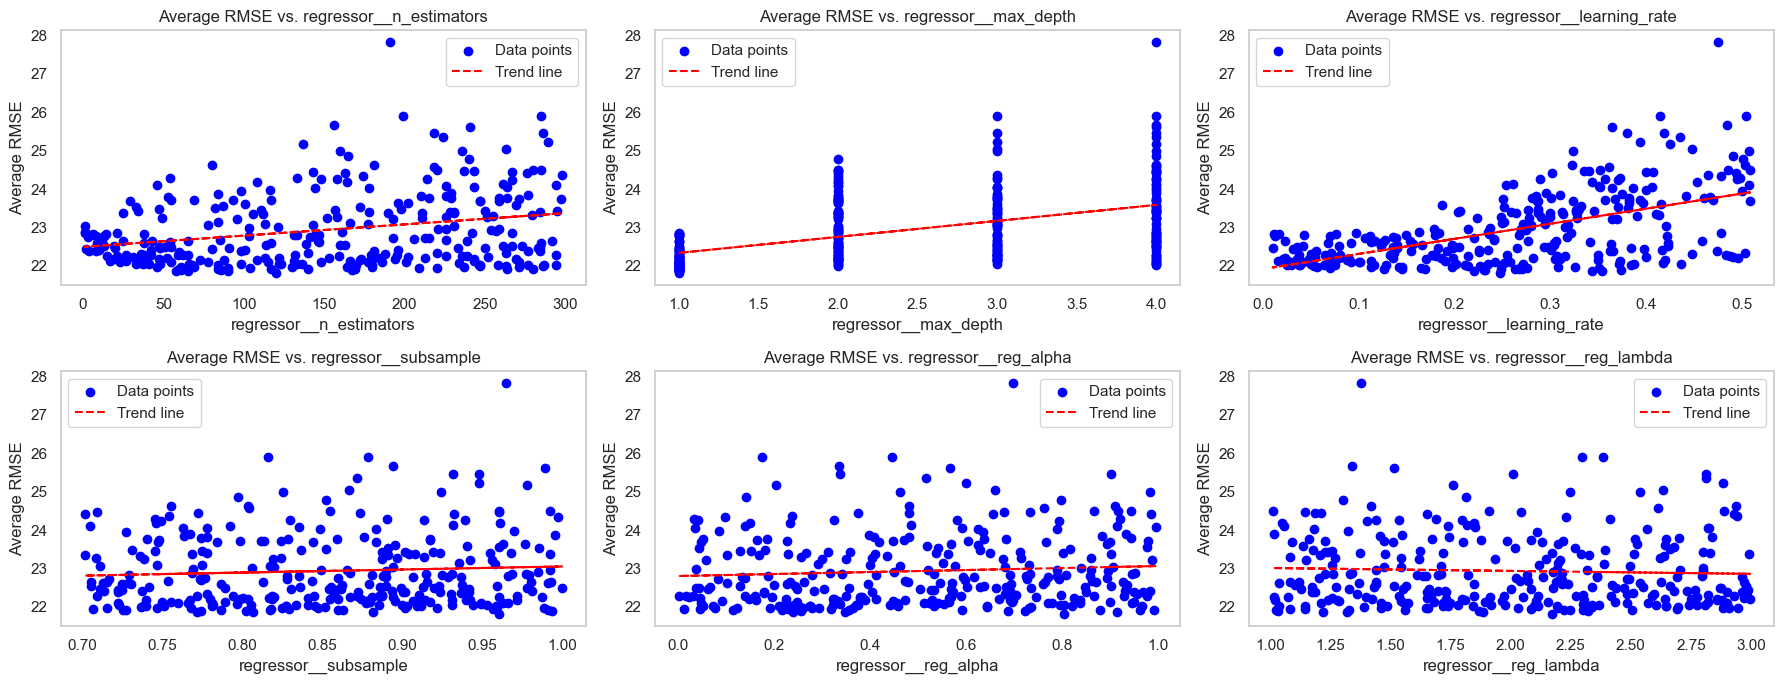

Plots generated successfully.


In [43]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np
import matplotlib.pyplot as plt
import time

# Define feature columns and target variable
feature_columns = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
X = feature_df[feature_columns]
y = feature_df['glucose']

# Extract patient IDs for Leave-One-Group-Out cross-validation
groups = feature_df['patient_id']

# Filter out data for patient 1
mask = ~feature_df['patient_id'].isin([1])
X_filtered, y_filtered, groups_filtered = X[mask], y[mask], groups[mask]

# Verify that groups_filtered is not empty and has valid values
print(f'Number of groups after filtering: {len(np.unique(groups_filtered))}')
print(f'Unique groups: {np.unique(groups_filtered)}')

# Define preprocessing steps
pipeline = Pipeline([
    ('preprocessor', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])),
    ('regressor', xgb.XGBRegressor())
])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'regressor__n_estimators': randint(1, 300),
    'regressor__max_depth': randint(1, 5),
    'regressor__learning_rate': uniform(0.01, 0.5),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__reg_alpha': uniform(0, 1),
    'regressor__reg_lambda': uniform(1, 2)
}

# Initialize Leave-One-Group-Out cross-validation
logo = LeaveOneGroupOut()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=300,  # Number of parameter settings to sample
    cv=logo,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV with status updates
start_time = time.time()
print("Starting RandomizedSearchCV...")
random_search.fit(X_filtered, y_filtered, groups=groups_filtered)
computation_time = time.time() - start_time

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert from negative MSE to positive MSE
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_score:.2f}')
print(f'Computation time: {computation_time:.2f} seconds')

# Plotting results with status updates
print("Generating plots...")
results = random_search.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# Extract RMSE values from the results
mean_rmse_scores = -mean_test_scores

plt.figure(figsize=(18, 7))

# List of parameters to plot
plot_params = ['regressor__n_estimators', 'regressor__max_depth', 'regressor__learning_rate',
                'regressor__subsample', 'regressor__reg_alpha', 'regressor__reg_lambda']

for i, param in enumerate(plot_params):
    plt.subplot(2, 3, i + 1)
    param_values = np.array([p[param] for p in params if param in p])
    avg_rmse = np.array([mean_rmse_scores[params.index(p)] for p in params if param in p])

    # Scatter plot
    plt.scatter(param_values, avg_rmse, c='blue', label='Data points')

    # Fit and plot trend line
    coeffs = np.polyfit(param_values, avg_rmse, 1)  # Linear fit (degree 1)
    trend_line = np.poly1d(coeffs)
    plt.plot(param_values, trend_line(param_values), color='red', linestyle='--', label='Trend line')

    plt.xlabel(param)
    plt.ylabel('Average RMSE')
    plt.title(f'Average RMSE vs. {param}')
    plt.grid(False)
    plt.legend()

    # Print status update for each parameter plot
    print(f'Plotting {param} vs. Average RMSE')

plt.tight_layout()
plt.show()
print("Plots generated successfully.")


#### Data Preparation and Model Evaluation

This script performs the following tasks:

1. **Data Preparation**:
   - Extracts the first 25% of each patient's data for training and testing.
   - Splits the training data into features and target variables.
   - Filters data from patient 2 for testing.

2. **Model Evaluation**:
   - Defines preprocessing steps using `SimpleImputer` and `StandardScaler`.
   - Implements a function to calculate Mean Absolute Percentage Error (MAPE).
   - Provides a function to evaluate model performance, including fitting the model, predicting values, and calculating various metrics such as MAE, MSE, RMSE, R2, and MAPE.

3. **Plotting Functions**:
   - **`plot_best_results`**: Plots true vs. predicted values for the best parameter, highlighting model predictions and actual values on a graph.
   - **`plot_rmse_vs_parameter`**: Visualizes RMSE against parameter values for model comparison, including a vertical line indicating the best parameter value.

The provided functions and plotting tools help in evaluating model performance effectively and visualizing the results for better analysis.


#### Random Forest Model LOGO-CV Evaluation

This script evaluates Random Forest models using LOGO CV with varying `n_estimators`, `max_depth`, and `max_features`. It performs the following:

1. **Preprocessing**: Creates a pipeline for imputation and scaling.
2. **Evaluation**:
   - Tests different parameter ranges.
   - Plots RMSE results for each parameter.
   - Identifies the best parameter values.

Use this to optimize Random Forest performance based on RMSE.


#### Final LOGO-CV Model Comparison and Results

Evaluating XGBoost...
Evaluating PLS Regression (n=6)...
Model Evaluation Results:
               Model  RMSE  MAPE
PLS Regression (n=6) 15.91 11.97
             XGBoost 15.84 11.56


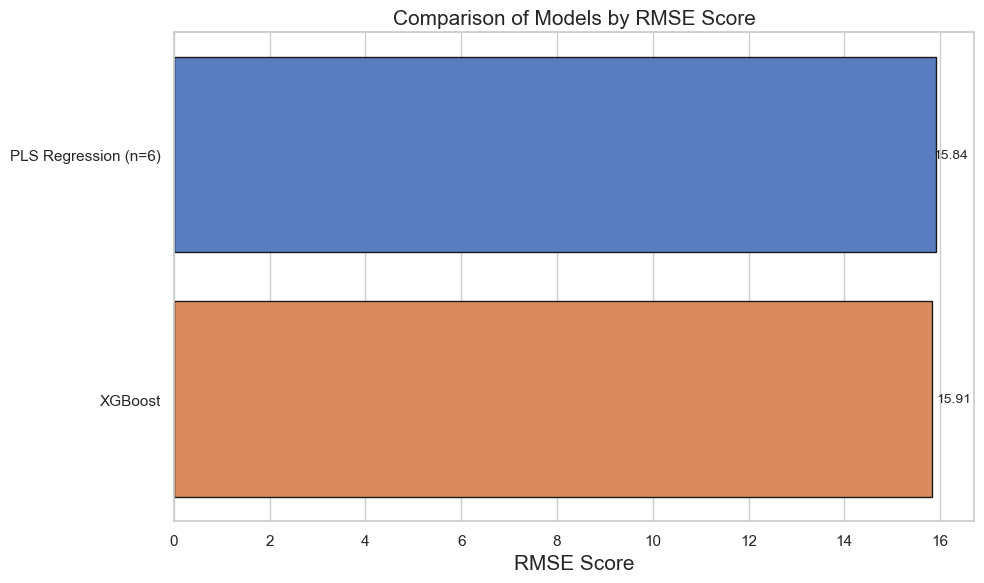

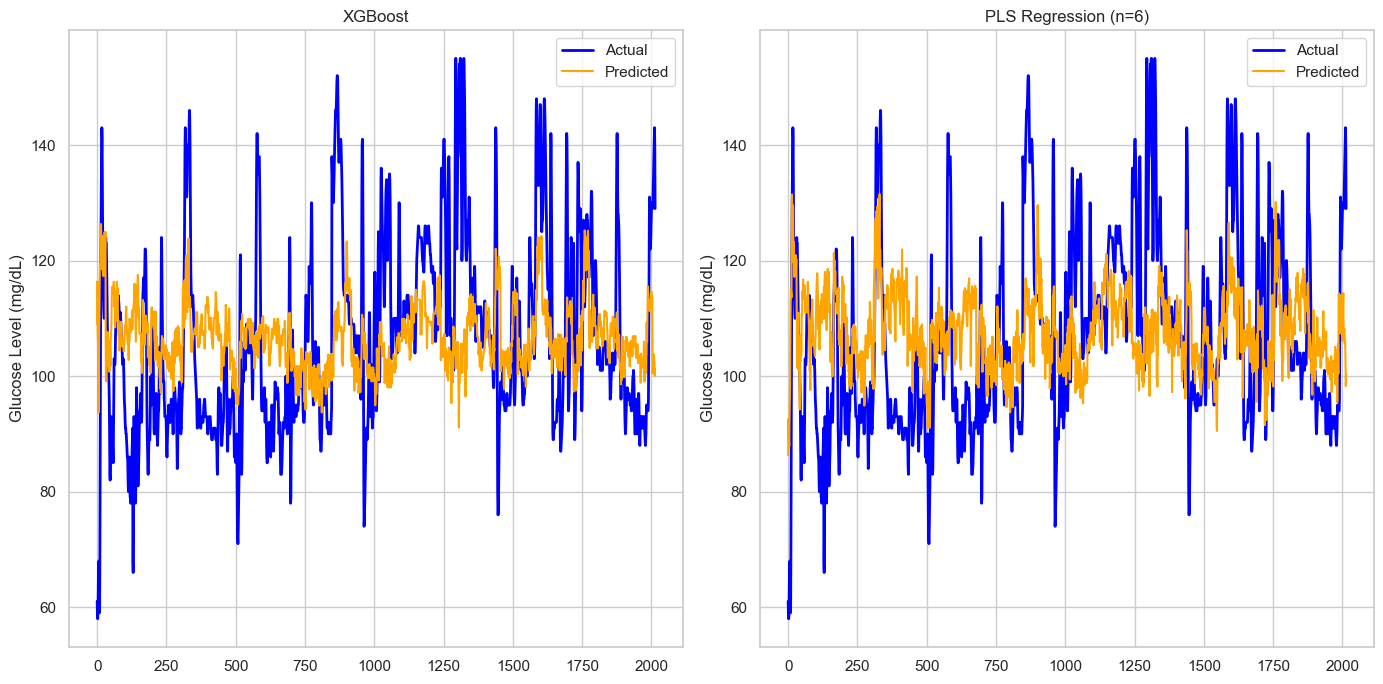

In [47]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.cross_decomposition import PLSRegression

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define the model with optimized hyperparameters
xgb_model = xgb.XGBRegressor(
    learning_rate=0.24731543787490695,
    max_depth=1,
    n_estimators=120,
    reg_alpha=0.8056701529500532,
    reg_lambda=2.170708728793504,
    subsample=0.9604813841539775,
    n_jobs=-1,
    random_state=42
)

# Define PLS Regression model
pls_model = PLSRegression(n_components=6)

# Define the models
models = {
    'XGBoost': xgb_model,
    'PLS Regression (n=6)': pls_model
}

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model_pipeline = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('regressor', model)
    ])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    computation_time = time.time() - start_time
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'computation_time': computation_time,
        'y_pred': y_pred,
        'y_test': y_test
    }
    return metrics

# Define feature columns and target variable
feature_columns = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
X = feature_df[feature_columns]
y = feature_df['glucose']

# Filter out data for training (patients 2-16) and testing (patient 1)
X_train = X[feature_df['patient_id'] != 1]
y_train = y[feature_df['patient_id'] != 1]
X_test = X[feature_df['patient_id'] == 1]
y_test = y[feature_df['patient_id'] == 1]

# Store results
results = []

# Perform evaluation for each model
for model_name, model in models.items():
    print(f'Evaluating {model_name}...')
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    metrics['Model'] = model_name
    results.append(metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Select and reorder relevant columns
results_table = results_df[['Model', 'RMSE', 'MAPE']].sort_values('RMSE', ascending=False)

# Format table values to two decimal places
pd.options.display.float_format = '{:.2f}'.format

# Print the table
print("Model Evaluation Results:")
print(results_table.to_string(index=False))

# Plot RMSE scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
chart = sns.barplot(x='RMSE', y='Model', data=results_table, palette='muted', edgecolor='k')

# Add RMSE scores to the end of the bars
for index, row in results_table.iterrows():
    chart.text(row['RMSE'] + 0.02, index, f'{row["RMSE"]:.2f}', va='center', ha='left', size=10)

plt.xlabel('RMSE Score', size=15)
plt.ylabel('')  # Remove y-label
plt.title('Comparison of Models by RMSE Score', size=15)
plt.tight_layout()
plt.show()

# Plot actual vs. predicted values
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models.items()):
    # Get y_pred and y_test for the current model
    metrics = next(result for result in results if result['Model'] == model_name)
    y_pred = metrics['y_pred']
    y_test = metrics['y_test']
    
    ax.plot(y_test.values, color='blue', label='Actual', linewidth=2)
    ax.plot(y_pred, color='orange', label='Predicted', linewidth=1.5)
    
    ax.set_title(model_name)
    ax.set_ylabel('Glucose Level (mg/dL)')
    ax.legend()

plt.tight_layout()
plt.show()


PLS has the lowest RMSE along with Random Forest

#### Model Evaluation on Test Subject - Patient 1

Evaluating Mean Regressor...
Evaluating PLS Regression...
Evaluating XGBoost...
Model Evaluation Results:
         Model  RMSE  MAPE
Mean Regressor 18.42 15.82
PLS Regression 15.91 11.97
       XGBoost 15.84 11.56


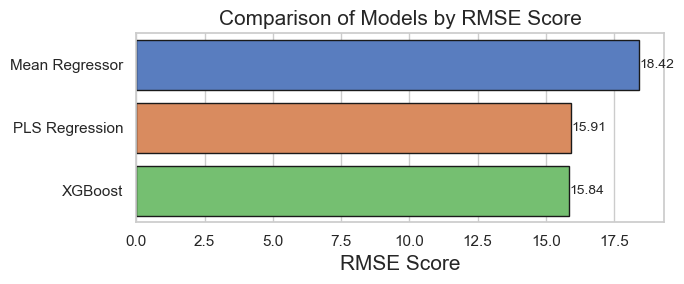

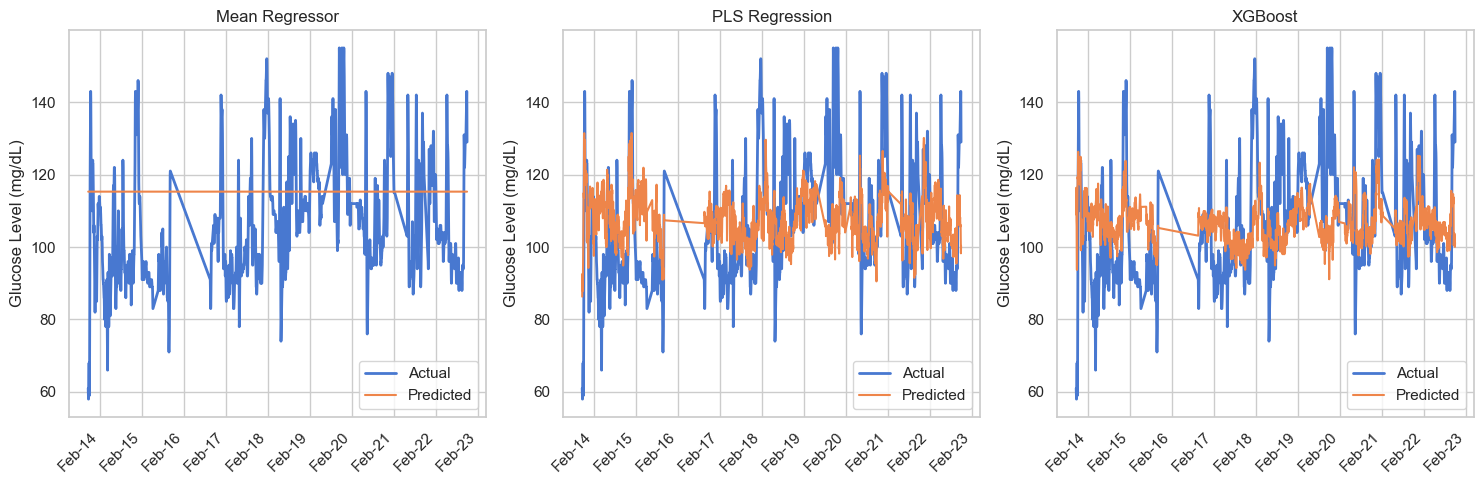

In [99]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.cross_decomposition import PLSRegression
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define models
models = {
    'Mean Regressor': DummyRegressor(strategy='mean'),
    'PLS Regression': PLSRegression(n_components=6),
    'XGBoost': xgb.XGBRegressor(
        learning_rate=0.24731543787490695,
        max_depth=1,
        n_estimators=120,
        reg_alpha=0.8056701529500532,
        reg_lambda=2.170708728793504,
        subsample=0.9604813841539775,
        n_jobs=-1,
        random_state=42)
}

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model_pipeline = Pipeline([
        ('preprocessor', preprocessing_pipeline),
        ('regressor', model)
    ])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    computation_time = time.time() - start_time
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'computation_time': computation_time,
        'y_pred': y_pred,
        'y_test': y_test
    }
    return metrics

# Ensure time index is in Datetime format
if not pd.api.types.is_datetime64_any_dtype(feature_df.index):
    feature_df.index = pd.to_datetime(feature_df.index)

# Define feature columns and target variable
feature_columns = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
X = feature_df[feature_columns]
y = feature_df['glucose']
groups = feature_df['patient_id']

# Filter out data for training (patients 2-16) and testing (patient 1)
train_filter = feature_df['patient_id'].isin(range(2, 17))
test_filter = feature_df['patient_id'] == 1

X_train, y_train, dates_train = X[train_filter], y[train_filter], feature_df.index[train_filter]
X_test, y_test, dates_test = X[test_filter], y[test_filter], feature_df.index[test_filter]

# Store results
results = []

# Perform evaluation for each model
for model_name, model in models.items():
    print(f'Evaluating {model_name}...')
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    metrics['Model'] = model_name
    metrics['dates_test'] = dates_test
    results.append(metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Select and reorder relevant columns
results_table = results_df[['Model', 'RMSE', 'MAPE']].sort_values('RMSE', ascending=False)

# Format table values to two decimal places
pd.options.display.float_format = '{:.2f}'.format

# Print the table
print("Model Evaluation Results:")
print(results_table.to_string(index=False))

# Plot RMSE scores
sns.set(style="whitegrid")
plt.figure(figsize=(7, 3))
chart = sns.barplot(x='RMSE', y='Model', data=results_table, palette='muted', edgecolor='k')

# Add RMSE scores to the end of the bars
for index, row in results_table.iterrows():
    chart.text(row['RMSE'] + 0.02, index, f'{row["RMSE"]:.2f}', va='center', ha='left', size=10)

plt.xlabel('RMSE Score', size=15)
plt.ylabel('')  # Remove y-label
plt.title('Comparison of Models by RMSE Score', size=15)
plt.tight_layout()
plt.show()

# Define color palette
palette = sns.color_palette('muted')

# Plot actual vs. predicted values
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (model_name, model) in zip(axes, models.items()):
    # Get y_pred and y_test for the current model
    metrics = next(result for result in results if result['Model'] == model_name)
    y_pred = metrics['y_pred']
    y_test = metrics['y_test']
    dates_test = metrics['dates_test']
    
    ax.plot(dates_test, y_test.values, color=palette[0], label='Actual', linewidth=2)
    ax.plot(dates_test, y_pred, color=palette[1], label='Predicted', linewidth=1.5)
    
    ax.set_title(model_name)
    ax.set_ylabel('Glucose Level (mg/dL)')
    ax.legend()
        # Set the x-axis format to Month-Day
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-tick labels

plt.tight_layout()
plt.show()


In [108]:
import pandas as pd

# Define model parameters, features, and hyperparameters
model_details = {
    'Model': ['Mean Regressor', 'PLS Regression', 'XGBoost'],
    'Feature Engineering': ['Standard Scaling, Mean Imputation', 'Standard Scaling, Mean Imputation', 'Standard Scaling, Mean Imputation'],
    'Parameters': [
        'Mean Regressor uses default parameters',
        'n_components=6',
        'learning_rate=0.247, max_depth=1, n_estimators=120, reg_alpha=0.806, reg_lambda=2.171, subsample=0.960'
    ],
    'MAE': results_df.set_index('Model')['MAE'],
    'MSE': results_df.set_index('Model')['MSE'],
    'RMSE': results_df.set_index('Model')['RMSE'],
    'R2': results_df.set_index('Model')['R2'],
    'MAPE': results_df.set_index('Model')['MAPE']
}

# Create a DataFrame for model details
model_details_df = pd.DataFrame(model_details)

# Define features (assuming they are the same for all models)
features = list(feature_columns)  # List of features used in the models

# Save model details to CSV
model_details_df.to_csv('model_metrics_submission.csv', index=False)

# Save features to a separate CSV file
features_df = pd.DataFrame({'Features': features})
features_df.to_csv('model_features_submission.csv', index=False)

print("Model metrics with features saved to 'model_metrics_with_features3.csv'")
print("Features saved to 'model_features.csv'")


Model metrics with features saved to 'model_metrics_with_features3.csv'
Features saved to 'model_features.csv'


Top 10 Feature Importances for XGBoost:
                        Feature  Importance
0                        Gender        0.11
1                         HbA1c        0.07
18                    acc_x_max        0.07
4                      eda_mean        0.06
122       food_sugar_sum_120min        0.06
8                       eda_std        0.06
146        acc_mean_cum_average        0.04
101        day_period_Afternoon        0.04
10                      eda_max        0.04
150  WakeTimePointsBinary3HrAvg        0.04

Top 10 Feature Importances for PLS Regression:
                        Feature  Importance
0                        Gender        3.93
1                         HbA1c        3.02
98                 day_of_month        2.52
145          hr_std_cum_average        2.45
99                   is_weekend        2.12
153           acc_mean_hist_avg        1.94
146        acc_mean_cum_average        1.94
101        day_period_Afternoon        1.46
122       food_sugar_sum_120min 

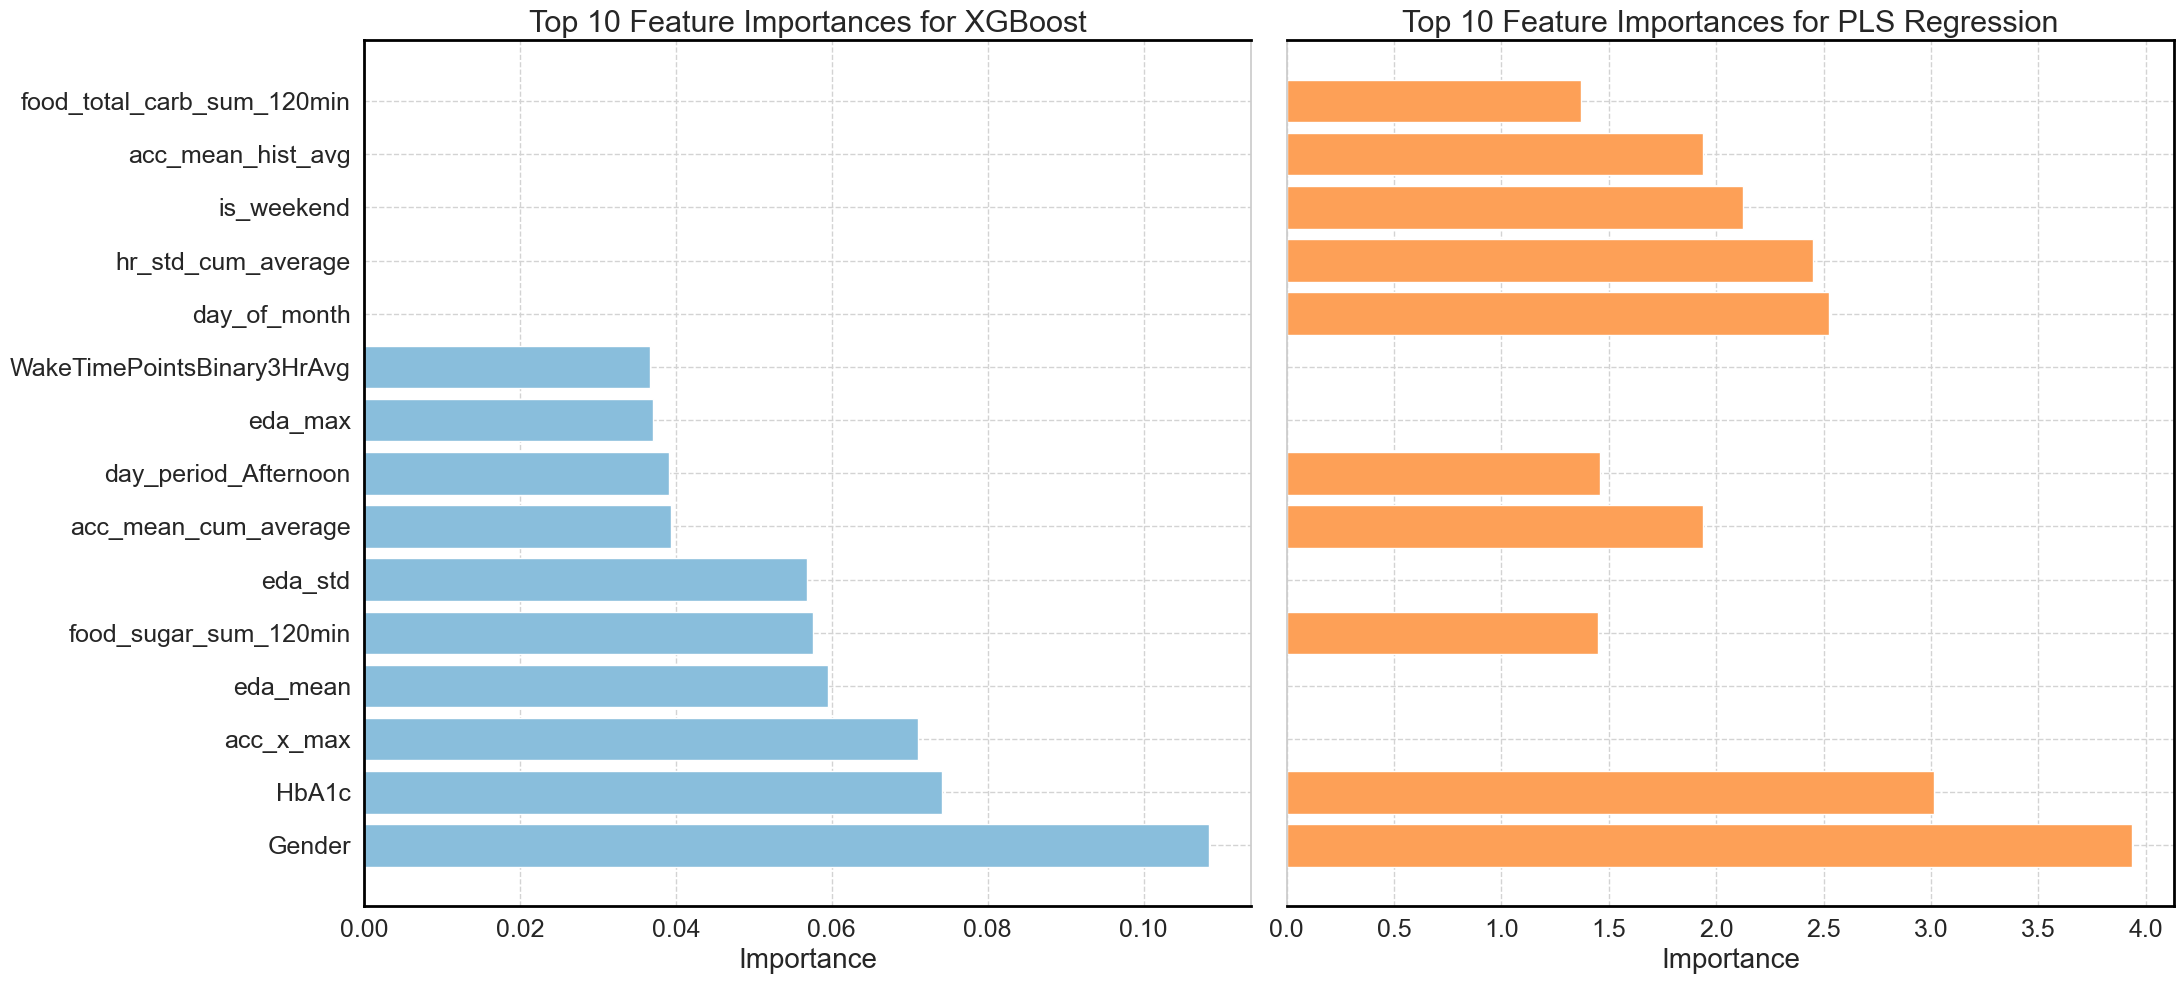

In [91]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# Extract models from the models dictionary
xgb_model = models['XGBoost']
pls_model = models['PLS Regression']

# Get feature importances for XGBoost
xgb_importance = xgb_model.feature_importances_
feature_names = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
xgb_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False).head(10)

# Get feature importances for PLS Regression
pls_weights = pls_model.coef_
pls_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(pls_weights.flatten())
}).sort_values(by='Importance', ascending=False).head(10)

# Print feature importances
print("Top 10 Feature Importances for XGBoost:")
print(xgb_feature_importances)
print("\nTop 10 Feature Importances for PLS Regression:")
print(pls_feature_importances)

# Set Seaborn style and palette
sns.set(style="whitegrid")
xgb_palette = sns.color_palette("Blues")[2]  # Light blue
pls_palette = sns.color_palette("Oranges")[2]  # Light orange

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 10), sharey=True)

# Plot XGBoost feature importances
bars_xgb = axes[0].barh(xgb_feature_importances['Feature'], xgb_feature_importances['Importance'], color=xgb_palette)
axes[0].set_xlabel('Importance', fontsize=20)
axes[0].set_title('Top 10 Feature Importances for XGBoost', fontsize=22)
axes[0].tick_params(axis='both', which='major', labelsize=18)
axes[0].invert_yaxis()  # Invert y-axis to show the highest importance on top

# Customizing XGBoost subplot
axes[0].spines['top'].set_edgecolor('black')
axes[0].spines['bottom'].set_edgecolor('black')
axes[0].spines['left'].set_edgecolor('black')
axes[0].spines['top'].set_linewidth(2)
axes[0].spines['bottom'].set_linewidth(2)
axes[0].spines['left'].set_linewidth(2)
axes[0].grid(True, linestyle='--', color='lightgray')

# Plot PLS Regression feature importances
bars_pls = axes[1].barh(pls_feature_importances['Feature'], pls_feature_importances['Importance'], color=pls_palette)
axes[1].set_xlabel('Importance', fontsize=20)
axes[1].set_title('Top 10 Feature Importances for PLS Regression', fontsize=22)
axes[1].tick_params(axis='both', which='major', labelsize=18)
axes[1].invert_yaxis()  # Invert y-axis to show the highest importance on top

# Customizing PLS Regression subplot
axes[1].spines['top'].set_edgecolor('black')
axes[1].spines['bottom'].set_edgecolor('black')
axes[1].spines['right'].set_edgecolor('black')
axes[1].spines['top'].set_linewidth(2)
axes[1].spines['bottom'].set_linewidth(2)
axes[1].spines['right'].set_linewidth(2)
axes[1].grid(True, linestyle='--', color='lightgray')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### After Study - Model performance as adding more patients

In [94]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb

# Define a simple mean model
class MeanPredictor(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.mean_ = y.mean()
        return self

    def predict(self, X):
        return np.full(shape=(X.shape[0],), fill_value=self.mean_)

# Define feature columns and target variable
feature_columns = [col for col in feature_df.columns if col not in ['glucose', 'patient_id']]
X = feature_df[feature_columns]
y = feature_df['glucose']

# Extract patient IDs for Leave-One-Group-Out cross-validation
groups = feature_df['patient_id']

# Initialize LeaveOneGroupOut
logo = LeaveOneGroupOut()

# Define preprocessing steps
imputer = SimpleImputer(strategy='mean')  # Fill missing values with the column mean
scaler = StandardScaler()  # Standardize features by removing mean and scaling to unit variance

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate model performance with LOGO CV
def evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold, test_idx, random_state=42):
    if hasattr(model, 'random_state'):
        try:
            model.set_params(random_state=random_state)
        except ValueError:
            pass

    pipeline = Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('regressor', model)
    ])

    start_time = time.time()

    # Fit the pipeline on the training data
    pipeline.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred = pipeline.predict(X_test_fold)

    end_time = time.time()
    computation_time = end_time - start_time

    # Calculate metrics
    mae = mean_absolute_error(y_test_fold, y_pred)
    mse = mean_squared_error(y_test_fold, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_fold, y_pred)
    mape = mean_absolute_percentage_error(y_test_fold, y_pred)

    # Returns a dictionary including models, metrics, and computation time
    return {
        'model': pipeline,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'predictions': y_pred,
        'computation_time': computation_time
    }

# Define a dictionary to map model names to actual model instances with hyperparameters
models = {
    'MeanPredictor': MeanPredictor(),  # No hyperparameters needed for MeanPredictor
    'PLSRegression': PLSRegression(
        n_components=11,       # Number of components to use
        scale=True            # Whether to scale the data before performing PLS
    ),
    'XGBoost': xgb.XGBRegressor(
        learning_rate=0.24731543787490695,
        max_depth=1,
        n_estimators=120,
        reg_alpha=0.8056701529500532,
        reg_lambda=2.170708728793504,
        subsample=0.9604813841539775,
        n_jobs=-1,
        random_state=42)
}

# Initialize dictionaries to store results for each subset of patients
average_rmses_by_train_size = {model_name: [] for model_name in models.keys()}
average_mapes_by_train_size = {model_name: [] for model_name in models.keys()}
train_sizes = []

# Loop through different training set sizes
for i in range(2, 17):  # Training on patients 3 to i
    # Ensure patient 3 is always included in the training set
    train_patients = [1] + list(range(2, i + 1))
    train_filter = feature_df['patient_id'].isin(train_patients)
    test_filter = ~feature_df['patient_id'].isin(train_patients)

    if len(feature_df['patient_id'].unique()) < 2:  # Ensure we have at least 2 unique groups
        continue

    X_train = X[train_filter]
    y_train = y[train_filter]
    groups_train = groups[train_filter]

    X_test = X[test_filter]
    y_test = y[test_filter]
    groups_test = groups[test_filter]

    # Perform LOGO cross-validation for each model
    for model_name, model in models.items():
        print(f'Evaluating {model_name} with training patients {train_patients}...')

        mae_scores = []
        mse_scores = []
        rmse_scores = []
        r2_scores = []
        mape_scores = []
        computation_times = []

        # Perform cross-validation
        for train_idx, test_idx in logo.split(X_train, y_train, groups=groups_train):
            X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

            # Evaluate model
            results = evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold, test_idx)

            # Append scores and computation time
            mae_scores.append(results['MAE'])
            mse_scores.append(results['MSE'])
            rmse_scores.append(results['RMSE'])
            r2_scores.append(results['R2'])
            mape_scores.append(results['MAPE'])
            computation_times.append(results['computation_time'])

        # Calculate average scores
        average_mae = np.mean(mae_scores)
        average_mse = np.mean(mse_scores)
        average_rmse = np.mean(rmse_scores)
        average_r2 = np.mean(r2_scores)
        average_mape = np.mean(mape_scores)
        average_computation_time = np.mean(computation_times)

        # Store the average RMSE and MAPE for the current training size and model
        average_rmses_by_train_size[model_name].append(average_rmse)
        average_mapes_by_train_size[model_name].append(average_mape)

    train_sizes.append(len(train_patients))




Evaluating MeanPredictor with training patients [1, 2]...
Evaluating PLSRegression with training patients [1, 2]...
Evaluating XGBoost with training patients [1, 2]...
Evaluating MeanPredictor with training patients [1, 2, 3]...
Evaluating PLSRegression with training patients [1, 2, 3]...
Evaluating XGBoost with training patients [1, 2, 3]...
Evaluating MeanPredictor with training patients [1, 2, 3, 4]...
Evaluating PLSRegression with training patients [1, 2, 3, 4]...
Evaluating XGBoost with training patients [1, 2, 3, 4]...
Evaluating MeanPredictor with training patients [1, 2, 3, 4, 5]...
Evaluating PLSRegression with training patients [1, 2, 3, 4, 5]...
Evaluating XGBoost with training patients [1, 2, 3, 4, 5]...
Evaluating MeanPredictor with training patients [1, 2, 3, 4, 5, 6]...
Evaluating PLSRegression with training patients [1, 2, 3, 4, 5, 6]...
Evaluating XGBoost with training patients [1, 2, 3, 4, 5, 6]...
Evaluating MeanPredictor with training patients [1, 2, 3, 4, 5, 6, 7].

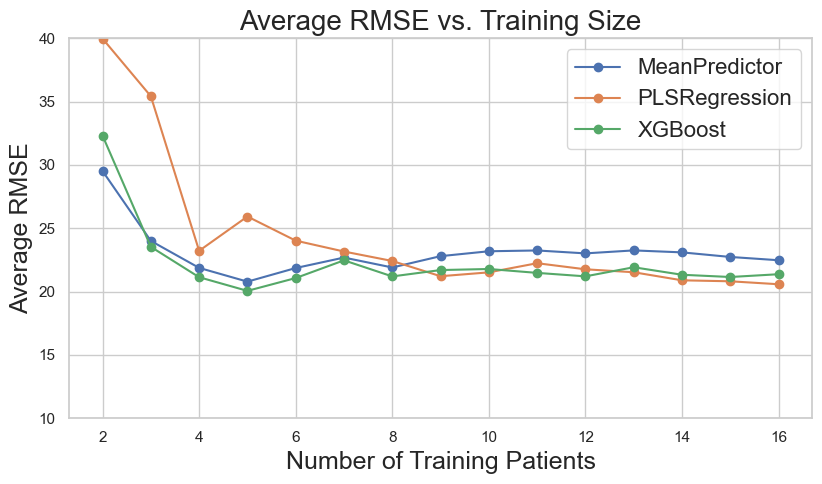

In [98]:
# Plotting RMSE and MAPE vs. training size
plt.figure(figsize=(16, 5))

# RMSE Plot
plt.subplot(1, 2, 1)
for model_name, rmses in average_rmses_by_train_size.items():
    plt.plot(train_sizes, rmses, marker='o', label=model_name)
plt.xlabel('Number of Training Patients', fontsize=18)
plt.ylabel('Average RMSE', fontsize=18)
plt.title('Average RMSE vs. Training Size', fontsize=20)
plt.ylim(10, 40)  # Set y-axis limits for RMSE
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()
